# getting observations with single words in each string

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/Users/Rutherford/Desktop/formerly on desktop/dataset.csv",
                 na_filter=False,names=['error','one','two'],header=None,
                 dtype={'error':np.int32,'one':str,'two':str})
df = df.replace("_","",regex=True)
df = df.replace("-"," ",regex=True)

In [3]:
print("all observations: ",df.shape)

df = df[(df['one'].apply(lambda x:len(x.split())==1)) & (df['two'].apply(lambda x:len(x.split())==1))]

print("both are one word: ",df.shape)

('all observations: ', (79135, 3))
('both are one word: ', (20474, 3))


In [4]:
def not_just_nums(string):
    try:
        int(string)
        return False
    except:
        return True

In [5]:
print("pure numbers in first column: ",df.shape[0]-sum(df['one'].apply(not_just_nums)))
print("pure numbers in second column: ",df.shape[0]-sum(df['two'].apply(not_just_nums)))

('pure numbers in first column: ', 6162)
('pure numbers in second column: ', 6187)


In [6]:
df = df[df['one'].apply(not_just_nums)]
df = df[df['two'].apply(not_just_nums)]

print("both are one word, and not just numbers: ",df.shape)

('both are one word, and not just numbers: ', (14209, 3))


In [7]:
#one_word_each.replace("\d{4,}","timestamp",regex=True)

In [8]:
df.replace(r"\ba\b","one",regex=True,inplace=True)

print("minors: ",sum(df['error']==1))
print("majors: ",sum(df['error']==2))

('minors: ', 7336)
('majors: ', 6873)


In [9]:
#no_numbers.to_csv("/Users/Rutherford/Desktop/singles.csv",header=False,index=False)

# remove observations with OOV

In [10]:
import os

In [11]:
data_path = "/Users/Rutherford/Desktop/formerly on desktop/data"
epsilon = 1e-4

w2v_dat = os.path.join(data_path,'embed.dat')
w2v_vocab = os.path.join(data_path,'embed.vocab')

# create word embeddings and mapping of vocabulary item to index
embeddings = np.memmap(w2v_dat, dtype=np.float64,
                            mode="r", shape=(3000000, 300))
with open(w2v_vocab) as f:
    vocab_list = map(lambda string: string.strip(), f.readlines())
vocab_dict = {w: i for i, w in enumerate(vocab_list)}

In [12]:
# not actually splitting, but getting a list of len 1
df['first_bad'] = df['one'].apply(lambda x:any([word not in vocab_dict for word in x.split()]))
df['second_bad'] = df['two'].apply(lambda x:any([word not in vocab_dict for word in x.split()]))
df['bad'] = df[['first_bad','second_bad']].apply(lambda x: any(x),axis=1)

print('Portion of remaining dataset that contains OOVs: {:.2%}'.format(sum(df['bad'])/float(len(df['bad']))))

Portion of remaining dataset that contains OOVs: 19.83%


In [13]:
df = df[['error','one','two']].loc[df['bad']==False]

print("single words in each, no pure numbers, no OOVs: ",df.shape)

print("minors: ",sum(df['error']==1))
print("majors: ",sum(df['error']==2))

('single words in each, no pure numbers, no OOVs: ', (11392, 3))
('minors: ', 5251)
('majors: ', 6141)


In [14]:
df

,error,one,two
8343,1,1st,first
8625,1,2nd,second
8642,1,zone,zoning
8785,1,3rd,third
8889,1,4th,fourth
8992,1,5th,fifth
9045,1,6th,six
9046,1,6th,sixth
9093,1,7in,in
9104,1,7th,seventh


In [15]:
# some trailing spaces
#df.replace(" ","",regex=True).iloc[428].values
#array([1, 'baked', 'baked'], dtype=object)
df.replace(" ","",regex=True,inplace=True)

# relabeling based on lemmas, stemming, etc

In [16]:
from nltk.stem import WordNetLemmatizer

In [17]:
lemmer = WordNetLemmatizer()

In [18]:
def lemmatizer(string):
    noun_based = lemmer.lemmatize(string)
    verb_based = lemmer.lemmatize(noun_based,pos='v')
    adj_based = lemmer.lemmatize(verb_based,pos='a')                
    
    return adj_based

In [19]:
lems_one = df['one'].apply(lemmatizer)
lems_two = df['two'].apply(lemmatizer)

df['one_lemma'] = lems_one
df['two_lemma'] = lems_two

In [20]:
print("same lemma, minors: ",sum(df.loc[df['one_lemma']==df['two_lemma'],'error']==1))
print("same lemma, majors: ",sum(df.loc[df['one_lemma']==df['two_lemma'],'error']==2))

('same lemma, minors: ', 2266)
('same lemma, majors: ', 775)


In [21]:
print("same lemma in both strings: ",df[df['one_lemma']==df['two_lemma']].shape)
print("same lemma yet marked as major: ",sum(df[df['one_lemma']==df['two_lemma']]['error']==2))

('same lemma in both strings: ', (3041, 5))
('same lemma yet marked as major: ', 775)


In [22]:
df.loc[df['one_lemma']==df['two_lemma'],'error']=1

df.tail()

,error,one,two,one_lemma,two_lemma
79105,2,you,yo,you,yo
79106,1,you,you,you,you
79107,1,you,you,you,you
79112,2,you,your,you,your
79120,2,you,you've,you,you've


In [23]:
str(lemmer.lemmatize('yourselves',pos='n'))

'yourselves'

In [24]:
from nltk.stem import PorterStemmer

In [25]:
ps = PorterStemmer()

ps.stem('yourselves')

u'yourselv'

In [26]:
df['one_port_stem'] = df['one'].apply(lambda x:ps.stem(x))
df['two_port_stem'] = df['two'].apply(lambda x:ps.stem(x))

In [27]:
# 223 that were same porter stem and labeled as 2
#df[(df['one_port_stem']==df['two_port_stem'])&(df['error']==2)]
df.loc[df['one_port_stem']==df['two_port_stem'],'error'] = 1

In [28]:
##df[['error','one','two']].to_csv("/Users/Rutherford/Desktop/singles.csv",header=False,index=False)

In [29]:
print("minors: ",sum(df['error']==1))
print("majors: ",sum(df['error']==2))

('minors: ', 6249)
('majors: ', 5143)


# Clustering based on distances

In [30]:
from scipy.spatial.distance import canberra,chebyshev,cosine,euclidean
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def get_distance(s1,s2,distance):

    S1_ = embeddings[vocab_dict[s1]]
    S2_ = embeddings[vocab_dict[s2]]
    
    measure = distance(S1_,S2_)
    
    return measure

In [32]:
# abandoned
#def get_diff(strings):
#    s1,s2 = strings['one'],strings['two']
#
#    S1_ = embeddings[vocab_dict[s1]]
#    S2_ = embeddings[vocab_dict[s2]]
#    
#    measure = S1_-S2_
#   
#    return measure

In [33]:
df.shape

(11392, 7)

In [34]:
df['can'] = df.apply(lambda row: get_distance(row['one'],row['two'],canberra),axis=1)
df['cheb'] = df.apply(lambda row: get_distance(row['one'],row['two'],chebyshev),axis=1)
df['cos'] = df.apply(lambda row: get_distance(row['one'],row['two'],cosine),axis=1)
df['euc'] = df.apply(lambda row: get_distance(row['one'],row['two'],euclidean),axis=1)

df.drop(['one_lemma','two_lemma','one_port_stem','two_port_stem'],axis=1,inplace=True)

In [35]:
def indexer(s_1,s_2):
    
    diffed = float(vocab_dict[s_2]-vocab_dict[s_1])
    summed = float(vocab_dict[s_2]+vocab_dict[s_1])
    normed = diffed/summed
    
    return normed

In [36]:
df['index_diff'] = df.apply(lambda row: indexer(row['one'],row['two']),axis=1)

In [37]:
from fuzzywuzzy import fuzz

In [38]:
df['ratio'] = df.apply(lambda row:fuzz.ratio(row['one'],row['two']),axis=1)

In [39]:
# norms
#df2['cos_norm'] = df2['cosine']-np.mean(df2['cosine'])
#df2['euc_norm'] = df2['euclidean']-np.mean(df2['euclidean'])
#df2['can_norm'] = df2['canberra']-np.mean(df2['canberra'])
#df2['cheb_norm'] = df2['chebyshev']-np.mean(df2['chebyshev'])
#df2['idx'] = idx

In [40]:
mins,majs = df.groupby('error')

### concatenated many of the following plots

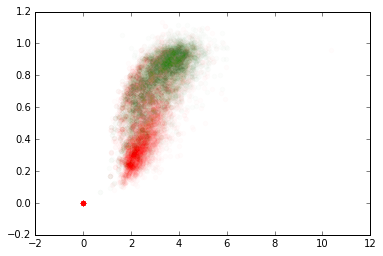

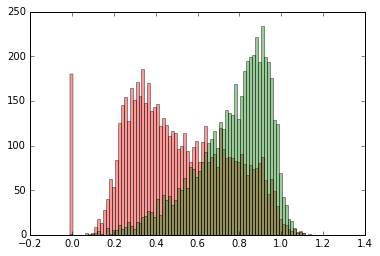

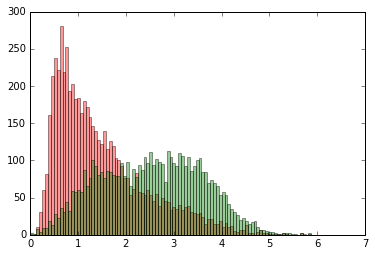

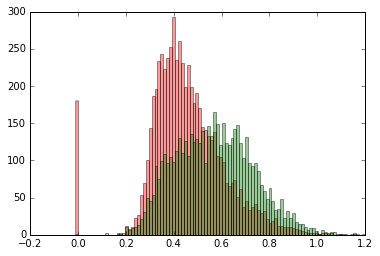

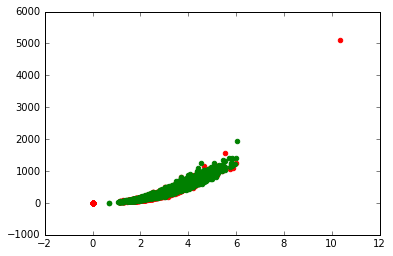

In [41]:
plt.figure(1)
plt.scatter(mins[1]['euc'],mins[1]['cos'],color="r",alpha=.01)
plt.scatter(majs[1]['euc'],majs[1]['cos'],color="g",alpha=.01);

plt.figure(2)
#mean_cos = np.mean(df['cos'])
bins = np.linspace(-.01,1.4,100)
plt.hist(mins[1]['cos'],bins,color='r',alpha=.4)
plt.hist(majs[1]['cos'],bins,color='g',alpha=.4);

plt.figure(3)
bins = np.linspace(.01,6,100)
plt.hist(mins[1]['euc']*mins[1]['cos'],bins,color='r',alpha=.4)
plt.hist(majs[1]['euc']*majs[1]['cos'],bins,color='g',alpha=.4);

plt.figure(4)
bins = np.linspace(-.01,1.2,100)
plt.hist(mins[1]['cheb'],bins,color='r',alpha=.4)
plt.hist(majs[1]['cheb'],bins,color='g',alpha=.4);

plt.figure(5)
plt.scatter(mins[1]['euc'],mins[1]['can']*mins[1]['cheb']*mins[1]['euc'],color="r")
plt.scatter(majs[1]['euc'],majs[1]['can']*majs[1]['cheb']*majs[1]['euc'],color="g");

In [42]:
#plt.scatter(mins[1]['euc_norm'],(mins[1]['can_norm']+mins[1]['cheb_norm'])*mins[1]['cos_norm'],color="r")
#plt.scatter(majs[1]['euc_norm'],(majs[1]['can_norm']+majs[1]['cheb_norm'])*majs[1]['cos_norm'],color="g")

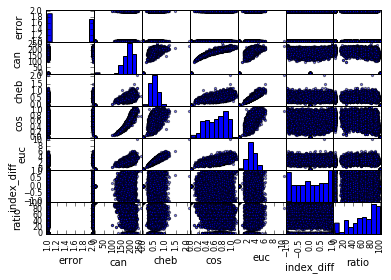

In [43]:
pd.scatter_matrix(df);

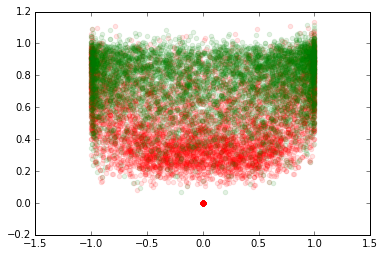

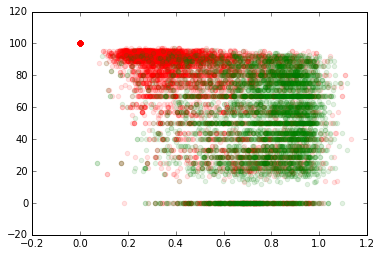

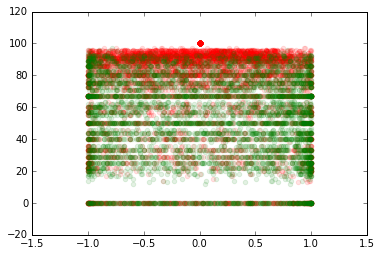

In [44]:
plt.figure(1)
plt.scatter(mins[1]['index_diff'],mins[1]['cos'],color="r",alpha=.11)
plt.scatter(majs[1]['index_diff'],majs[1]['cos'],color="g",alpha=.11);

plt.figure(2)
plt.scatter(mins[1]['cos'],mins[1]['ratio'],color="r",alpha=.11)
plt.scatter(majs[1]['cos'],majs[1]['ratio'],color="g",alpha=.11);

plt.figure(3)
plt.scatter(mins[1]['index_diff'],mins[1]['ratio'],color="r",alpha=.11)
plt.scatter(majs[1]['index_diff'],majs[1]['ratio'],color="g",alpha=.11);

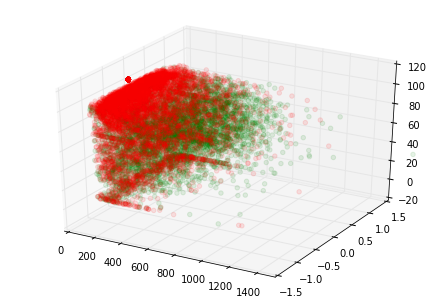

In [45]:
from mpl_toolkits.mplot3d import Axes3D
import pylab

fig = pylab.figure()
ax = Axes3D(fig,xlim=(0,1500))

# multiplying distances, mostly as exploration

ax.scatter(mins[1]['can']*mins[1]['cos']*mins[1]['cheb']*mins[1]['euc'], 
           mins[1]['index_diff'], 
           mins[1]['ratio'],
           color='r',alpha=.1)
ax.scatter(majs[1]['can']*majs[1]['cos']*majs[1]['cheb']*majs[1]['euc'], 
           majs[1]['index_diff'], 
           majs[1]['ratio'],
           color='g',alpha=.1)
plt.show()

### shuffling data for SVM

In [47]:
indices = df.index.values.tolist()
np.random.seed(35)
np.random.shuffle(indices)
df_shuff = df.ix[indices]

print(df.shape[0], "observations")
print(int(df.shape[0]*.75), "observations in train set")

(11392, 'observations')
(8544, 'observations in train set')


In [48]:
X_train = df_shuff.iloc[range(8544)]
y_train = X_train.pop('error')

X_test = df_shuff.iloc[range(8544,11392)]
y_test = X_test.pop('error')

In [49]:
from sklearn.svm import SVC

In [50]:
svc = SVC(kernel='poly',degree=3)
svc.fit(X_train.iloc[:50][['cos','index_diff','ratio']],y_train[:50])
#svc.fit(X_train[['cos','index_diff','ratio']],y_train)
#svc.fit(X_train[['cos','euc','cheb','can','index_diff','ratio']],y_train)
#svc.fit(X_train.iloc[:200][['cos','euc','cheb','can','index_diff','ratio']],y_train[:200])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
svc.score(X_test[['cos','index_diff','ratio']],y_test)
#svc.score(X_test[['cos','euc','cheb','can','index_diff','ratio']],y_test)

0.6952247191011236

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
confusion_matrix(y_test,svc.predict(X_test[['cos','index_diff','ratio']]))

array([[1394,  210],
       [ 658,  586]])

In [54]:
print("{} actual minors".format(sum(y_test==1)))
print("{} actual majors".format(sum(y_test==2)))

1604 actual minors
1244 actual majors


### manually checked observations with cos > .82 labeled as minor

In [55]:
#df[(df['cos']>.82)&(df['error']==1)]
# leaving things like s6 -> s alone, or instances where removing fillers and metas would make it moot

# should in fact be minor: 
back_to_minor = np.asarray([9527, 12048, 12548, 13166, 13815, 
                           14061, 14063, 14097, 14229, 14563, 
                           15365, 16410, 16411, 17232, 17256, 
                           17583, 18061, 18763, 19052, 19153, 
                           21078, 21148, 21449, 21607, 21957, 
                           22802, 22955, 25225, 28678, 29163, 
                           29718, 31787, 32712, 32752, 33194, 
                           33198, 33328, 33431, 33798, 37590, 
                           37693, 38846, 40564, 42035, 42910, 
                           42951, 42953, 43705, 44385, 46102, 
                           49535, 49544, 53294, 54184, 56839, 
                           56840, 58921, 62707, 72940])


In [56]:
# reassigning
df.loc[df['cos']>.82,'error']=2
df.loc[back_to_minor,'error']=1

In [57]:
mins,majs = df.groupby('error')

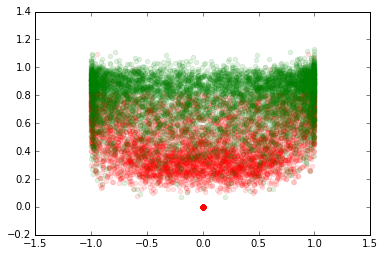

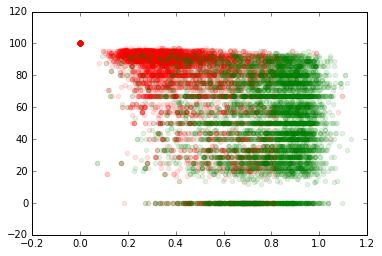

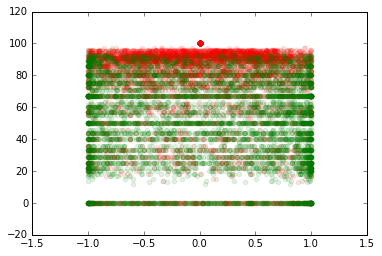

In [58]:
plt.figure(1)
plt.scatter(mins[1]['index_diff'],mins[1]['cos'],color="r",alpha=.11)
plt.scatter(majs[1]['index_diff'],majs[1]['cos'],color="g",alpha=.11);
plt.figure(2)
plt.scatter(mins[1]['cos'],mins[1]['ratio'],color="r",alpha=.11)
plt.scatter(majs[1]['cos'],majs[1]['ratio'],color="g",alpha=.11);
plt.figure(3)
plt.scatter(mins[1]['index_diff'],mins[1]['ratio'],color="r",alpha=.11)
plt.scatter(majs[1]['index_diff'],majs[1]['ratio'],color="g",alpha=.11);

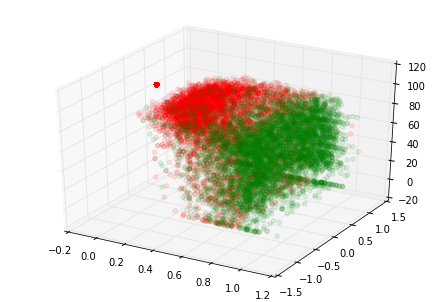

In [59]:
fig = pylab.figure()
ax = Axes3D(fig)

ax.scatter(mins[1]['cos'], 
           mins[1]['index_diff'], 
           mins[1]['ratio'],
           color='r',alpha=.1)
ax.scatter(majs[1]['cos'], 
           majs[1]['index_diff'], 
           majs[1]['ratio'],
           color='g',alpha=.1)
plt.show()

### had previously forgotten to reassign df_shuff with relabeled instances

### the following cell was run each time after relabeling

In [205]:
df_shuff = df.ix[indices]

print(df.shape[0], "observations")
print(int(df.shape[0]*.75), "observations in train set")

X_train = df_shuff.iloc[range(8544)]
y_train = X_train.pop('error')

X_test = df_shuff.iloc[range(8544,11392)]
y_test = X_test.pop('error')

(11392, 'observations')
(8544, 'observations in train set')


In [206]:
svc = SVC(kernel='poly',degree=2)
svc.fit(X_train[['cos','index_diff','ratio']],y_train)
#svc.fit(X_train[['cos','index_diff','ratio']],y_train) # degree 2 poly kernel -- 74.1
#svc.fit(X_train.iloc[:100][['cos','index_diff','ratio']],y_train[:100]) # degree 2 poly kernel -- 74.5 or so

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
# before reassigning            : 0.74122191011235961 ... array([[1209,  395],[ 342,  902]])
# after reassigning (FPs)       : 0.8107443820224719 ... array([[1108,  301],[ 238, 1201]])
# after reassigning (FPs) again : 0.8753511235955056 ... array([[1103,  112],[ 243, 1390]])
# after reassigning (FPs) third : 0.8932584269662921 ... array([[1103,   61],[ 243, 1441]])
# after reassigning (FNs)       : 0.9058988764044944 ... array([[1139,   61],[ 207, 1441]])

In [208]:
svc.score(X_test[['cos','index_diff','ratio']],y_test)

0.9058988764044944

In [209]:
results = svc.predict(X_test[['cos','index_diff','ratio']])
confusion_matrix(y_test,results)

array([[1139,   61],
       [ 207, 1441]])

## iterative process of reassigning, fitting, predicting, examining FPs...

In [175]:
# indices of FPs
FPs = X_test.iloc[np.where((results==2)&(y_test==1))[0].tolist()].index.values

## vast majority of these were in fact majors (remember -- did this several times)

### manually checking FPs and noting which ones should actually be minor before changing the others to major

In [ ]:
# just making sure these are the FPs
#svc.predict(df_shuff.loc[FPs,['cos','index_diff','ratio']]) # all 2
#y_test[FPs] # all 1
#all(svc.predict(df_shuff[['cos','index_diff','ratio']].ix[FPs])==2) # True

### went through 30 at a time to check accuracy of labels

In [ ]:
# second reassignment

#df_shuff.ix[FPs] 
back_to_minor_again = np.asarray([51676, 23688, 28657, 52735, 44385, 19148, 
                                  46293, 42732, 50443, 33798, 33475, 15030, 
                                  40621, 12548, 16410, 29152, 30066, 53487, 
                                  56089, 23684, 40564, 10208, 41321, 32503, 
                                  54147, 42951, 33298, 53294, 21449, 31475, 
                                  56086, 23993, 12295, 33198, 42953, 52620, 
                                  18026, 35624])
#np.intersect1d(back_to_minor,back_to_minor_again)

df.loc[FPs,'error']=2
df.loc[back_to_minor_again,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [158]:
# third reassignment

previous_minors = np.union1d(back_to_minor,back_to_minor_again)
new_FPs = np.setdiff1d(FPs,previous_minors)

#df_shuff.ix[new_FPs][29:]
back_to_minor_third = np.asarray([9702, 10646, 12236, 12286, 16329, 
                                  16824, 19308, 21936, 28790, 30201, 
                                  33496, 39059, 40538, 46263, 51991, 
                                  52621, 52731, 52750, 53405, 54339, 
                                  62942, 68951])

df.loc[new_FPs,'error']=2
df.loc[back_to_minor_third,'error']=1

# THEN went back and reassigned train/test sets before fitting again

#written out after third relabeling
#df.to_csv("/Users/Rutherford/Desktop/relabeled_singles_with_svm.csv")

In [178]:
# no more FPs to be relabeled in this train/test split
previous_minors_again = np.union1d(previous_minors,back_to_minor_third)
np.setdiff1d(FPs,previous_minors_again)

array([], dtype=int64)

## one pass of reassigning a portion of FNs as minors

In [190]:
FNs = X_test.iloc[np.where((results==1)&(y_test==2))[0].tolist()].index.values

In [200]:
#df.loc[FNs][203:]
back_to_minor_from_FN = np.asarray([76638, 78166, 63331, 66642, 62172, 
                                    63584, 61264, 78506, 67954, 59940, 
                                    72515, 65791, 65424, 61032, 78353, 
                                    77018, 77654, 57759, 59374, 77017, 
                                    60947, 79002, 67189, 75427, 61928, 
                                    60391, 68045, 69431, 76648, 75343, 
                                    67238, 68175, 72870, 68183, 75408, 
                                    71088])

df.loc[back_to_minor_from_FN,'error']=1

# THEN went back and reassigned train/test sets before fitting again

## changing train/test split to get to relabeling other examples

In [449]:
df_shuff = df.ix[indices]

print(df.shape[0], "observations")
print(int(df.shape[0]*.75), "observations in train set")

#X_train = df_shuff.iloc[range(8544)] # 0:8543
#X_train = df_shuff.iloc[2848:11392] # 2848:11392
#X_train = pd.concat([df_shuff.iloc[5696:],df_shuff.iloc[:2848]]) # 5696:11392 U 0:2848
X_train = pd.concat([df_shuff.iloc[8544:],df_shuff.iloc[:5696]]) # 8544:11392 U 0:5696
y_train = X_train.pop('error')

#X_test = df_shuff.iloc[range(8544,11392)] # 8544:11392
#X_test = df_shuff.iloc[:2848] # 0:2848
#X_test = df_shuff.iloc[2848:5696] # 2848:5696
X_test = df_shuff.iloc[5696:8544] # 2848:5696
y_test = X_test.pop('error')

(11392, 'observations')
(8544, 'observations in train set')


In [ ]:
## ROUND 1 (from above)
# before reassigning            : 0.74122191011235961 ... array([[1209,  395],[ 342,  902]])
# after reassigning (FPs)       : 0.8107443820224719 ... array([[1108,  301],[ 238, 1201]])
# after reassigning (FPs) again : 0.8753511235955056 ... array([[1103,  112],[ 243, 1390]])
# after reassigning (FPs) third : 0.8932584269662921 ... array([[1103,   61],[ 243, 1441]])
# after reassigning (FNs)       : 0.9058988764044944 ... array([[1139,   61],[ 207, 1441]])

## ROUND 2
# before reassigning     : 0.8009129213483146 ... array([[1044,  331],[ 236, 1237]])
# after reassigning FPs  : 0.8964185393258427 ... array([[1044,   59],[ 236, 1509]])
# after reassigning FNs  : 0.9146769662921348 ... array([[1096,   64],[ 179, 1509]])

## ROUND 3
# before reassigning     : 0.80758426966292129 ... array([[1009,  315],[ 233, 1291]])
# after reassigning FPs  : 0.891502808988764   ... array([[1009,   76],[ 233, 1530]])
# after reassigning FNs  : 0.9080056179775281  ... array([[1056,   76],[ 186, 1530]])

## ROUND 4
# before reassigning     : 0.8068820224719101  ... array([[ 986,  379],[ 171, 1312]])
# after reassigning FPs  : 0.8978230337078652  ... array([[ 986,  120],[ 171, 1571]])
# after reassigning FNs  : 0.9143258426966292  ... array([[1033,  120],[ 124, 1571]])

In [450]:
svc = SVC(kernel='poly',degree=2)
svc.fit(X_train[['cos','index_diff','ratio']],y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [451]:
svc.score(X_test[['cos','index_diff','ratio']],y_test)

0.9143258426966292

In [452]:
results = svc.predict(X_test[['cos','index_diff','ratio']])
confusion_matrix(y_test,results)

array([[1033,  120],
       [ 124, 1571]])

In [352]:
FPs = X_test.iloc[np.where((results==2)&(y_test==1))[0].tolist()].index.values

In [353]:
#all_previous_minors = np.union1d(previous_minors_again,np.union1d(back_to_minor_four,back_to_minor_from_FN))
all_previous_minors = np.union1d(all_previous_minors,back_to_minor_from_FN_again)

In [354]:
#new_FPs = np.setdiff1d(FPs,previous_minors_again)
new_FPs = np.setdiff1d(FPs,all_previous_minors)

In [257]:
#df_shuff.ix[new_FPs][258:]
back_to_minor_four = np.asarray([8343, 8642, 10351, 13160, 13256, 14156, 
            14374, 16086, 16323, 19078, 19490, 21025, 
            21581, 23087, 23927, 23975, 26224, 27772, 
            28024, 28326, 28686, 29205, 31531, 32734, 
            34015, 34233, 37079, 39887, 41999, 44523, 
            45833, 45997, 49214, 49806, 50424, 51273, 
            52043, 53481, 55846, 58432, 63095, 68220, 
            69545, 71880, 76654])

df.loc[new_FPs,'error']=2
df.loc[back_to_minor_four,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [298]:
FNs = X_test.iloc[np.where((results==1)&(y_test==2))[0].tolist()].index.values

In [310]:
#df_shuff.ix[FNs][203:]
back_to_minor_from_FN_again = np.asarray([68109, 56697, 72411, 78527, 79000, 57183, 75942, 
            62240, 60400, 65088, 60572, 69842, 64176, 60121, 
            77724, 59348, 63342, 78840, 60941, 70376, 67200, 
            76765, 72574, 61927, 75337, 60099, 65789, 60970, 
            72602, 57122, 63972, 72295, 61918, 78147, 56695, 
            59274, 61953, 65605, 72825, 71418, 63809, 66131, 
            62117, 60942, 77048, 60969, 57816, 64115, 61297, 
            56833, 67950, 78893, 59409, 67998, 68642, 61954, 69887])

df.loc[back_to_minor_from_FN_again,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [ ]:
# 3rd split

In [366]:
#df_shuff.ix[new_FPs][261:]
back_to_minor_five = np.asarray([10197, 10207, 10748, 12194, 13912, 14587, 14635, 
                                 15010, 15909, 18624, 19480, 20274, 20667, 21130, 
                                 22529, 23654, 23657, 23925, 23947, 24016, 24455, 
                                 26824, 26908, 27997, 28027, 28633, 28859, 29774, 
                                 31432, 31793, 33947, 35664, 36192, 37666, 39326, 
                                 39510, 39661, 39835, 40637, 40785, 41038, 41518, 
                                 44986, 46527, 48014, 48057, 48327, 49694, 50193, 
                                 52356, 52424, 52625, 53398, 53480, 54813, 54919, 
                                 55306, 55626, 59568, 59811, 59899, 60412, 61489, 
                                 63235, 69962, 70886, 71985])

df.loc[new_FPs,'error']=2
df.loc[back_to_minor_five,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [381]:
all_previous_minors = np.union1d(all_previous_minors,back_to_minor_five)
FNs = X_test.iloc[np.where((results==1)&(y_test==2))[0].tolist()].index.values
#np.intersect1d(FNs,all_previous_minors) # empty because you're only dealing with true majors

In [393]:
#df_shuff.ix[FNs][174:]
back_to_minor_from_FN_three = np.asarray([67840, 74683, 71304, 62229, 67747, 63044, 70379, 
            79081, 62256, 72333, 63727, 77239, 62356, 61955, 
            63801, 67800, 66128, 79112, 75421, 72508, 76639, 
            58410, 63723, 61555, 63449, 72686, 78363, 69205, 
            57847, 63625, 60641, 60482, 67565, 75967, 66376, 
            72369, 64303, 63343, 58707, 71956, 71866, 69986, 
            61916, 60365, 59513, 76776, 67283])

df.loc[back_to_minor_from_FN_three,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [ ]:
# 4th split

In [410]:
FPs = X_test.iloc[np.where((results==2)&(y_test==1))[0].tolist()].index.values
all_previous_minors = np.union1d(all_previous_minors,back_to_minor_from_FN_three)
new_FPs = np.setdiff1d(FPs,all_previous_minors)

In [427]:
#df_shuff.ix[new_FPs][309:]
back_to_minor_six = np.asarray([9251, 10740, 11798, 12968, 13390, 13914, 15087, 
                                15358, 15450, 15567, 15650, 15920, 15933, 16749, 
                                17228, 17261, 18107, 18110, 18689, 19738, 20113, 
                                20420, 21570, 21943, 23276, 23623, 23627, 23803, 
                                23895, 23954, 27385, 27699, 28001, 28030, 28269, 
                                28317, 28321, 28636, 28688, 28694, 28804, 29206, 
                                30177, 30482, 32470, 32494, 32891, 33022, 33169, 
                                33691, 33763, 33922, 35419, 37989, 38188, 38841, 
                                39235, 39911, 40009, 41221, 41481, 41664, 46127, 
                                46348, 46775, 47562, 48124, 48149, 48282, 48292, 
                                48925, 51107, 51989, 51993, 51994, 52082, 52085, 
                                52545, 52729, 52748, 52759, 53022, 53085, 53595, 
                                54888, 55228, 55514, 55741, 55883, 55930, 55980, 
                                58136, 58435, 61708, 62440, 63210, 69547, 70216, 
                                70284, 70488, 71809, 72320, 76637])

df.loc[new_FPs,'error']=2
df.loc[back_to_minor_six,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [438]:
all_previous_minors = np.union1d(all_previous_minors,back_to_minor_six)
FNs = X_test.iloc[np.where((results==1)&(y_test==2))[0].tolist()].index.values
np.intersect1d(all_previous_minors,FNs) # should be empty

array([], dtype=int64)

In [445]:
#df_shuff.ix[FNs][116:]
back_to_minor_from_FN_four = np.asarray([78507, 58705, 63546, 78354, 72294, 61164, 61983, 
            79120, 69633, 73360, 78480, 77010, 61743, 64078, 
            73039, 59598, 75450, 56586, 77005, 77651, 72039, 
            61112, 71132, 67707, 77762, 62745, 63423, 78189, 
            61824, 62429, 78569, 61262, 66096, 66465, 59212, 
            61425, 61152, 76944, 69412, 78036, 75425, 69891, 
            59410, 57638, 71024, 69206, 63578])

df.loc[back_to_minor_from_FN_four,'error']=1

# THEN went back and reassigned train/test sets before fitting again

In [453]:
all_previous_minors = np.union1d(all_previous_minors,back_to_minor_from_FN_four)

In [457]:
FPs = X_test.iloc[np.where((results==2)&(y_test==1))[0].tolist()].index.values
new_FPs = np.setdiff1d(FPs,all_previous_minors)

In [454]:
df.to_csv("/Users/Rutherford/Desktop/relabeled_singles_with_svm.csv")

In [456]:
"""mins,majs = df.groupby('error')

fig = pylab.figure(figsize=(9,6))
ax = Axes3D(fig)
ax.set_xlabel('Vector Cosine Distance')
ax.set_ylabel('Maximum Word Index Difference\n (proxy for rarity)')
ax.set_zlabel('String Match Ratio')

ax.scatter(mins[1]['cos'], 
           mins[1]['index_diff'], 
           mins[1]['ratio'],
           color='r',alpha=.1,label="minor")
ax.scatter(majs[1]['cos'], 
           majs[1]['index_diff'], 
           majs[1]['ratio'],
           color='g',alpha=.1,label="major")
ax.legend(loc= "upper left")

plt.savefig("/Users/Rutherford/Desktop/3d_later.png")"""

'mins,majs = df.groupby(\'error\')\n\nfig = pylab.figure(figsize=(9,6))\nax = Axes3D(fig)\nax.set_xlabel(\'Vector Cosine Distance\')\nax.set_ylabel(\'Maximum Word Index Difference\n (proxy for rarity)\')\nax.set_zlabel(\'String Match Ratio\')\n\nax.scatter(mins[1][\'cos\'], \n           mins[1][\'index_diff\'], \n           mins[1][\'ratio\'],\n           color=\'r\',alpha=.1,label="minor")\nax.scatter(majs[1][\'cos\'], \n           majs[1][\'index_diff\'], \n           majs[1][\'ratio\'],\n           color=\'g\',alpha=.1,label="major")\nax.legend(loc= "upper left")\n\nplt.savefig("/Users/Rutherford/Desktop/3d_later.png")'

In [66]:
from sklearn.svm import NuSVC

In [121]:
nv = NuSVC(kernel='poly',degree=2)
nv.fit(X_train.iloc[:250][['cos','cheb','index_diff','ratio']],y_train[:250]) 
#nv.fit(X_train.iloc[:2500][['cos','index_diff','ratio']],y_train[:2500]) 
# 100: 0.72616 200: 0.7356 500:.74333 1000: 0.7444 2500: 0.7461

NuSVC(cache_size=200, class_weight={1: 0.3, 2: 0.7}, coef0=0.0,
   decision_function_shape=None, degree=2, gamma='auto', kernel='poly',
   max_iter=-1, nu=0.5, probability=False, random_state=None,
   shrinking=True, tol=0.001, verbose=False)

In [122]:
nv.score(X_test[['cos','cheb','index_diff','ratio']],y_test)

0.74122191011235961

In [124]:
confusion_matrix(y_test,nv.predict(X_test[['cos','cheb','index_diff','ratio']]))

array([[1179,  425],
       [ 312,  932]])

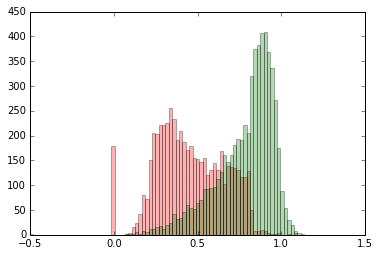

In [182]:
bins = np.linspace(-.5,1.5,100)
plt.hist(mins[1]['cos'],bins,color='r',alpha=.3)
plt.hist(majs[1]['cos'],bins,color='g',alpha=.3);

In [240]:
df[(df['cos']>.6)&(df['cos']<.82)&(df['error']==1)]

,error,one,two,can,cheb,cos,euc,index_diff,ratio
8642,1,zone,zoning,194.220102,0.767578,0.771112,4.346241,0.607635,60
9045,1,6th,six,204.099622,0.458008,0.806913,2.904340,-0.946558,0
9246,1,aac,ase,186.118404,0.549805,0.646247,3.372707,0.102981,33
9251,1,one,an,208.281121,0.413086,0.785853,2.355542,-0.250000,40
9264,1,one,any,195.060503,0.293060,0.601989,1.860850,0.383562,33
9268,1,one,as,198.354925,0.343750,0.728374,1.783957,-0.525424,0
9271,1,one,at,205.854894,0.333008,0.770008,1.928853,-0.578947,0
9344,1,about,above,201.366699,0.556641,0.813837,2.822834,0.902128,60
9359,1,about,at,197.939381,0.473633,0.736484,2.208331,-0.586207,57
9374,1,about,if,192.234564,0.403809,0.714228,2.242284,0.313433,0


In [242]:
df[(df['cos']<.6)&(df['error']==2)]

,error,one,two,can,cheb,cos,euc,index_diff,ratio
56406,2,about,around,175.621291,0.390625,0.561435,2.108859,0.605150,55
56419,2,about,how,183.916532,0.396973,0.587797,2.316198,0.502703,25
56458,2,abut,about,152.867653,0.380859,0.343379,1.852758,-0.998708,89
56499,2,accrued,accrual,171.776646,0.579102,0.447950,3.225888,0.395293,71
56529,2,across,cross,175.013506,0.466797,0.591757,2.768082,0.638632,91
56573,2,actually,acually,175.409466,0.298340,0.488958,1.572963,0.998277,93
56575,2,actually,anyway,159.896011,0.270508,0.315130,1.424214,0.647586,43
56586,2,actually,really,157.383969,0.331055,0.368412,1.714819,-0.594714,57
56589,2,actually,still,178.102510,0.341797,0.565148,1.828242,-0.714015,46
56665,2,adopt,adapt,181.397974,0.544922,0.561457,3.074559,0.263725,80


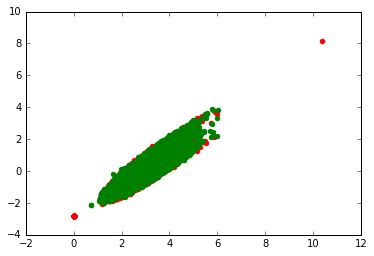

In [323]:
#plt.scatter(mins[1]['euclidean'],mins[1]['euc_norm']+mins[1]['cosine']*mins[1]['idx'],color="r")
#plt.scatter(majs[1]['euclidean'],majs[1]['euc_norm']+majs[1]['cosine']*majs[1]['idx'],color="g")

In [86]:
df.loc[df['error']==2,['error','one','two']]

,error,one,two
56343,2,one,amazing
56350,2,one,apparel
56356,2,one,av
56371,2,ability,humility
56372,2,ability,mobility
56378,2,abject,object
56379,2,able,abel
56382,2,able,happy
56383,2,able,have
56384,2,able,okay


In [87]:
from sklearn.cluster import KMeans
km = KMeans()

In [90]:
df.columns

Index([u'error', u'one', u'two', u'can', u'cheb', u'cos', u'euc',
       u'index_diff'],
      dtype='object')

In [94]:
#km.fit_transform(df[['can','cheb','cos','euc','index_diff']])
df['cluster'] = km.fit_predict(df[['can','cheb','cos','euc','index_diff']])

In [97]:
mins,majs = df.groupby('error')

In [102]:
min0,min1,min2,min3,min4,min5,min6,min7 = mins[1].groupby('cluster')

In [105]:
maj0,maj1,maj2,maj3,maj4,maj5,maj6 = majs[1].groupby('cluster')

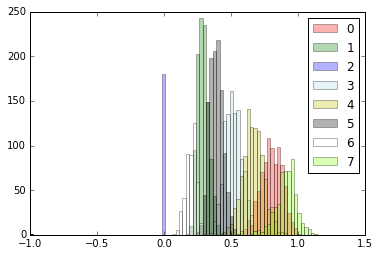

In [135]:
bins = np.linspace(-1,1.5,100)
plt.hist(min0[1]['cos'],bins,color='r',alpha=.3,label='0')
plt.hist(min1[1]['cos'],bins,color='g',alpha=.3,label='1')
plt.hist(min2[1]['cos'],bins,color='b',alpha=.3,label='2')
plt.hist(min3[1]['cos'],bins,color='lightblue',alpha=.3,label='3')
plt.hist(min4[1]['cos'],bins,color='y',alpha=.3,label='4')
plt.hist(min5[1]['cos'],bins,color='k',alpha=.3,label='5')
plt.hist(min6[1]['cos'],bins,color='w',alpha=.3,label='6')
plt.hist(min7[1]['cos'],bins,color='chartreuse',alpha=.3,label='7')
plt.legend(loc='upper right')
plt.show();

In [146]:
# relabel that last group
df.loc[min7[1].index,'error']=2

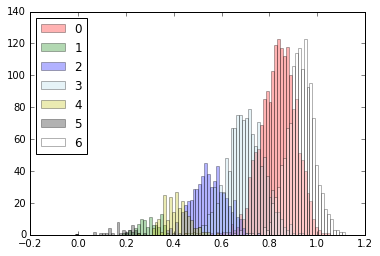

In [159]:
bins = np.linspace(-.01,1.2,100)
plt.hist(maj0[1]['cos'],bins,color='r',alpha=.3,label='0')
plt.hist(maj1[1]['cos'],bins,color='g',alpha=.3,label='1')
plt.hist(maj2[1]['cos'],bins,color='b',alpha=.3,label='2')
plt.hist(maj3[1]['cos'],bins,color='lightblue',alpha=.3,label='3')
plt.hist(maj4[1]['cos'],bins,color='y',alpha=.3,label='4')
plt.hist(maj5[1]['cos'],bins,color='k',alpha=.3,label='5')
plt.hist(maj6[1]['cos'],bins,color='w',alpha=.3,label='6')
plt.legend(loc='upper left')
plt.show();

In [162]:
# relabel tiny group 5
df.loc[maj5[1].index,'error']=1

In [163]:
df

,error,one,two,can,cheb,cos,euc,index_diff,cluster
8343,1,1st,first,182.145397,0.352539,5.277977e-01,2.348126,-0.977203,3
8625,1,2nd,second,165.943615,0.345459,4.056334e-01,2.129845,-0.955321,5
8642,1,zone,zoning,194.220102,0.767578,7.711123e-01,4.346241,0.607635,4
8785,1,3rd,third,165.465395,0.396973,4.048273e-01,2.138203,-0.929939,5
8889,1,4th,fourth,174.397973,0.384033,4.506717e-01,2.308431,-0.861066,3
8992,1,5th,fifth,169.125836,0.364746,4.198259e-01,2.269296,-0.744900,5
9045,1,6th,six,204.099622,0.458008,8.069128e-01,2.904340,-0.946558,0
9046,1,6th,sixth,162.645076,0.408691,4.145846e-01,2.300399,-0.694823,5
9093,2,7in,in,215.258097,0.549316,9.250077e-01,3.199329,-0.999993,7
9104,1,7th,seventh,160.037032,0.462891,3.983608e-01,2.351102,-0.619992,5


In [164]:
df[['error','one','two']].to_csv("/Users/Rutherford/Desktop/singles.csv",header=False,index=False)

In [167]:
from fuzzywuzzy import fuzz

In [170]:
df['ratio'] = df.apply(lambda row: fuzz.ratio(row['one'],row['two']),axis=1)

In [180]:
test = np.load("/Users/Rutherford/Desktop/X.npy")

In [182]:
test.shape

(11392, 608)

# POS tagging

In [83]:
import nltk

In [92]:
lemmer.lemmatize("")

'i thinks'

In [88]:
lemmer.lemmatize("he'd",pos='v')

"he'd"

In [86]:
simple_tagger("he's")

[u'PRON', u'VERB']

In [78]:
# too many tags
def tagger(string):
    tags = []
    words = nltk.word_tokenize(string)
    words_and_tags = nltk.pos_tag(words)
    for word,tag in words_and_tags:
        tags.append(tag)
    return tags

In [79]:
from nltk.tag import map_tag,pos_tag

In [80]:
def simple_tagger(string):
    tokens = nltk.word_tokenize(string)
    tagged = pos_tag(tokens)
    simplified = [(map_tag('en-ptb', 'universal', tag)) for word, tag in tagged]
    return simplified

In [89]:
simple_tagger('this is something and you are nothing')

[u'DET', u'VERB', u'NOUN', u'CONJ', u'PRON', u'VERB', u'NOUN']

In [90]:
df['one_tags'] = df['one_lems'].apply(simple_tagger)
df['two_tags'] = df['two_lems'].apply(simple_tagger)

In [91]:
df

,error,one,two,one_lems,two_lems,one_port_stem,two_port_stem,one_tags,two_tags
8343,1,1st,first,1st,first,1st,first,[NUM],[ADV]
8625,1,2nd,second,2nd,second,2nd,second,[NUM],[ADJ]
8642,1,zone,zoning,zone,zone,zone,zone,[NOUN],[NOUN]
8785,1,3rd,third,3rd,third,3rd,third,[NUM],[ADJ]
8889,1,4th,fourth,4th,fourth,4th,fourth,[NUM],[ADJ]
8992,1,5th,fifth,5th,fifth,5th,fifth,[NOUN],[NOUN]
9045,1,6th,six,6th,six,6th,six,[NUM],[NUM]
9046,1,6th,sixth,6th,sixth,6th,sixth,[NUM],[NOUN]
9093,1,7in,in,7in,in,7in,in,[NUM],[ADP]
9104,1,7th,seventh,7th,seventh,7th,seventh,[NOUN],[NOUN]


In [129]:
df_tags = np.union1d(np.unique(df['one_tags']),np.unique(df['two_tags']))
df_tags

array([[u'ADJ'], [u'ADJ', u'VERB'], [u'ADP'], [u'ADV'], [u'ADV', u'PRT'],
       [u'ADV', u'VERB'], [u'CONJ'], [u'DET'], [u'DET', u'VERB'],
       [u'NOUN'], [u'NOUN', u'.'], [u'NOUN', u'NOUN'], [u'NOUN', u'PRT'],
       [u'NOUN', u'VERB'], [u'NUM'], [u'NUM', u'PRT'], [u'PRON'],
       [u'PRON', u'.'], [u'PRON', u'VERB'], [u'VERB'], [u'VERB', u'ADV'],
       [u'VERB', u'NOUN'], [u'VERB', u'VERB']], dtype=object)

In [137]:
tag_dict = {k:v for v,k in enumerate([str(tag) for tag in df_tags])}

In [143]:
def tag_mapper(tag):
    string = str(tag)
    return tag_dict[string]

In [146]:
df['one_tag_num'] = df['one_tags'].apply(tag_mapper)
df['two_tag_num'] = df['two_tags'].apply(tag_mapper)

In [148]:
df

,error,one,two,one_lems,two_lems,one_port_stem,two_port_stem,one_tags,two_tags,one_tag_num,two_tag_num
8343,1,1st,first,1st,first,1st,first,[NUM],[ADV],14,3
8625,1,2nd,second,2nd,second,2nd,second,[NUM],[ADJ],14,0
8642,1,zone,zoning,zone,zone,zone,zone,[NOUN],[NOUN],9,9
8785,1,3rd,third,3rd,third,3rd,third,[NUM],[ADJ],14,0
8889,1,4th,fourth,4th,fourth,4th,fourth,[NUM],[ADJ],14,0
8992,1,5th,fifth,5th,fifth,5th,fifth,[NOUN],[NOUN],9,9
9045,1,6th,six,6th,six,6th,six,[NUM],[NUM],14,14
9046,1,6th,sixth,6th,sixth,6th,sixth,[NUM],[NOUN],14,9
9093,1,7in,in,7in,in,7in,in,[NUM],[ADP],14,2
9104,1,7th,seventh,7th,seventh,7th,seventh,[NOUN],[NOUN],9,9


In [149]:
df[['error','one','two','one_tag_num','two_tag_num']].to_csv("/Users/Rutherford/Desktop/singles.csv",header=False,index=False)

## just tests below... safe to delete if you don't fiddle with generator again

In [154]:
np.genfromtxt("/Users/Rutherford/Desktop/singles.csv",delimiter=",",usecols=(3,4))

array([[ 14.,   3.],
       [ 14.,   0.],
       [  9.,   9.],
       ..., 
       [ 16.,  16.],
       [ 16.,  16.],
       [ 16.,  18.]])

In [162]:
X_in = np.genfromtxt("/Users/Rutherford/Desktop/singles.csv",
                      delimiter=',',usecols=(1,2),dtype=str)

In [171]:
from scipy.spatial.distance import euclidean,cosine,canberra,chebyshev
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from pyemd import emd
epsilon = 1e-4


In [178]:
X_tags = np.genfromtxt("/Users/Rutherford/Desktop/singles.csv",
                                   delimiter=',',usecols=(3,4))

In [179]:
def _get_dist(s_1,s_2,distances,wmd):

    results_ = []

    # actual words
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum (OR mean) of word embeddings per string
    # no longer need for OOV or blank checks
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features]]

    # CHANGED THIS TO MEAN
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])+1e-50
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])+1e-50
    #diff = S2_-S1_
    results_.extend(S1_)
    results_.extend(S2_)
    #results.extend(diff)

    if distances:
        results_.append(canberra(S1_,S2_))
        results_.append(chebyshev(S1_,S2_))
        results_.append(cosine(S1_,S2_))
        results_.append(euclidean(S1_,S2_))

    if wmd:
        # fit CV on words with or without a single quote
        vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
        features = np.asarray(vect.get_feature_names())
        W_ = embeddings[[vocab_dict[w] for w in features]]

        # get 'flow' vectors
        v_1, v_2 = vect.transform([s_1, s_2])
        v_1 = v_1.toarray().ravel().astype(np.float64)
        v_2 = v_2.toarray().ravel().astype(np.float64)

        # normalize vectors so as not to reward shorter strings in WMD
        v_1 /= (v_1.sum()+epsilon)
        v_2 /= (v_2.sum()+epsilon)

        # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
        D_euclidean = euclidean_distances(W_).astype(np.float64)
        D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

        # using EMD (Earth Mover's Distance) from PyEMD
        distances_euclidean = emd(v_1,v_2,D_euclidean)
        distances_cosine = emd(v_1,v_2,D_cosine)

        # both WMD calculations (euclidean and cosine)
        results_.append(distances_euclidean)
        results_.append(distances_cosine)

    return np.asarray(results_,dtype=np.float).reshape([-1,606])

In [191]:
X=[]
for i,strings in enumerate(X_in[:10]):
    scores = _get_dist(strings[0],strings[1],True,True)
    scores = np.append(scores,X_tags[i])
    X.extend(scores)

In [193]:
X

[0.220703125,
 0.068359375,
 0.06689453125,
 0.1494140625,
 -0.0556640625,
 -0.162109375,
 -0.35546875,
 0.078125,
 0.1484375,
 0.039794921875,
 -0.205078125,
 -0.1103515625,
 -0.1318359375,
 0.0966796875,
 -0.0205078125,
 -0.10205078125,
 0.12255859375,
 -0.181640625,
 -0.09228515625,
 -0.2373046875,
 -0.21484375,
 -0.171875,
 -0.0966796875,
 -0.01806640625,
 -0.11181640625,
 -0.162109375,
 0.09423828125,
 0.001922607421875,
 0.10107421875,
 0.2734375,
 -0.2109375,
 -0.150390625,
 -0.02001953125,
 -0.220703125,
 0.095703125,
 0.046142578125,
 -0.053466796875,
 0.02001953125,
 -0.0234375,
 -0.044921875,
 -0.06005859375,
 -0.193359375,
 0.11376953125,
 0.1298828125,
 0.205078125,
 0.068359375,
 0.1318359375,
 -0.1259765625,
 -0.0028228759765625,
 0.17578125,
 0.050048828125,
 0.146484375,
 0.357421875,
 0.2890625,
 -0.0196533203125,
 0.08154296875,
 -0.1220703125,
 -0.016845703125,
 -0.171875,
 -0.09716796875,
 -0.2451171875,
 -0.1875,
 -0.02685546875,
 -0.2041015625,
 -0.0791015625,
 0

In [ ]:
from nltk.tag import map_tag,pos_tag

In [195]:
test_tags = np.asarray([[u'ADJ'], [u'ADJ', u'VERB'], [u'ADP'], [u'ADV'], [u'ADV', u'PRT'],
       [u'ADV', u'VERB'], [u'CONJ'], [u'DET'], [u'DET', u'VERB'],
       [u'NOUN'], [u'NOUN', u'.'], [u'NOUN', u'NOUN'], [u'NOUN', u'PRT'],
       [u'NOUN', u'VERB'], [u'NUM'], [u'NUM', u'PRT'], [u'PRON'],
       [u'PRON', u'.'], [u'PRON', u'VERB'], [u'VERB'], [u'VERB', u'ADV'],
       [u'VERB', u'NOUN'], [u'VERB', u'VERB']], dtype=object)

In [196]:
{k:v for v,k in enumerate([str(tag) for tag in test_tags])}

{"[u'ADJ', u'VERB']": 1,
 "[u'ADJ']": 0,
 "[u'ADP']": 2,
 "[u'ADV', u'PRT']": 4,
 "[u'ADV', u'VERB']": 5,
 "[u'ADV']": 3,
 "[u'CONJ']": 6,
 "[u'DET', u'VERB']": 8,
 "[u'DET']": 7,
 "[u'NOUN', u'.']": 10,
 "[u'NOUN', u'NOUN']": 11,
 "[u'NOUN', u'PRT']": 12,
 "[u'NOUN', u'VERB']": 13,
 "[u'NOUN']": 9,
 "[u'NUM', u'PRT']": 15,
 "[u'NUM']": 14,
 "[u'PRON', u'.']": 17,
 "[u'PRON', u'VERB']": 18,
 "[u'PRON']": 16,
 "[u'VERB', u'ADV']": 20,
 "[u'VERB', u'NOUN']": 21,
 "[u'VERB', u'VERB']": 22,
 "[u'VERB']": 19}

In [201]:
newdf = pd.read_csv("/Users/Rutherford/Desktop/11_23_dataset.csv",header=None,names=['error','one','two'])

In [202]:
newdf

,error,one,two
0,2,zone,zones
1,2,zero,four zero
2,2,zebra,zebra' russell crowe
3,2,yup,up
4,2,you,you virtually
5,2,you,you get paid back
6,2,you,you a
7,2,you will,people
8,2,you were,that you're
9,2,you,we're starting to


In [204]:
from sklearn.cluster import KMeans

In [205]:
km = KMeans()

In [ ]:
km.fit(df[''])

In [212]:
cosine(embeddings[vocab_dict['first']],embeddings[vocab_dict['1st']])

0.52779771673642717

In [213]:
embeddings[vocab_dict['first']]-embeddings[vocab_dict['1st']]

memmap([-0.09814453, -0.15771484, -0.03991699, -0.07568359,  0.11962891,
       -0.00976562,  0.18066406, -0.17724609,  0.07617188,  0.0793457 ,
        0.17236328, -0.11035156,  0.15588379, -0.03027344,  0.02109146,
       -0.04443359, -0.08081055,  0.09326172,  0.20703125,  0.26184082,
        0.08691406,  0.24755859, -0.078125  , -0.046875  ,  0.05273438,
        0.16702271, -0.06921387,  0.04421997, -0.01220703,  0.00195312,
        0.046875  ,  0.06933594, -0.07324219,  0.25610352, -0.05102539,
       -0.00366211, -0.04956055, -0.20361328,  0.07128906,  0.08642578,
        0.16552734, -0.08007812, -0.04980469, -0.03710938, -0.06835938,
        0.11132812, -0.08984375,  0.0715332 , -0.00737   , -0.16113281,
        0.04467773, -0.19824219, -0.21386719, -0.16113281, -0.09216309,
        0.00146484,  0.07177734, -0.0456543 ,  0.18560791,  0.07946777,
        0.06347656,  0.14282227, -0.03417969,  0.02050781,  0.00292969,
        0.04309082,  0.04608154,  0.02392578, -0.13549805, -0.1